In [5]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from pycocotools.coco import COCO
import requests
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from eval.metrics import Metrics
from services.settings import settings
import json

In [6]:
# set parameters
k = 10
threshold = 0.3
last_index = 500

options_without_all = ["first", "concat","random"]
options_with_all = ["avg_embed", "highest_singular_score","avg_score"]

all_queries_path = os.path.join(settings.project_root_dir,"src/eval/extended_queries.json" )
all_queries = json.load(open(all_queries_path))
response_dict_path = os.path.join(settings.output_dir, "response_dict_" + str(last_index) +".json")

encoder_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
url_prefix="http://images.cocodataset.org/val2017/"

/usr/prakt/s0077/miniconda3/envs/image-search/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
def set_coco_object(data_dir):
    ann_file = os.path.join(data_dir, 'annotations/captions_val2017.json')
    coco = COCO(ann_file)
    return coco

def embed_text(text,embedder):
    return embedder.encode([text])

def get_image_urls(img_ids, coco):
    img_urls = []
    for img_id in img_ids:
        img = coco.loadImgs(img_id)[0]
        img_urls.append(img['coco_url'])
    return img_urls

def get_coco_image_captions(coco, image_id):
    annIds = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(annIds)
    captions = [ann['caption'] for ann in anns]
    return captions

def fetch_image(url):
    image = Image.open(requests.get(url, stream=True).raw)
    return image

def show_images(img_urls):
    fig, axs = plt.subplots(1, len(img_urls), figsize=(20, 20))
    for i, url in enumerate(img_urls):
        img = fetch_image(url)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

embedder = SentenceTransformer('all-MiniLM-L6-v2')
coco = set_coco_object('../../data/coco-images')    
   

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [8]:
get_image_urls([184791], coco)

['http://images.cocodataset.org/val2017/000000184791.jpg']

In [19]:
# Metric related functions
def get_scores(retrieved_files, gt_retrieved_files, performance_dict):
    performance_dict["precision"].append(Metrics.precision(retrieved_files, gt_retrieved_files))
    performance_dict["recall"].append(Metrics.recall(retrieved_files, gt_retrieved_files))
    performance_dict["f1"].append(Metrics.f1_score(retrieved_files, gt_retrieved_files))
    performance_dict["nDCG"].append(Metrics.ndcg(retrieved_files, gt_retrieved_files, 5))
    return performance_dict

In [16]:
def search(query, K, SIZE,performance_dict, avg_embed_sim=False, highest_singular_sim=False, highest_avg_sim=False):
    query_embedding = embed_text(query, embedder)
    img_ids = [int(line.strip()) for line in open('../../data/coco_embeddings/coco_image_ids_' + str(SIZE) +'.txt')]
    
    # load GIT embeddings and calculate similarities with the query embedding, then get top K images
    git_embeddings = np.load('../../data/git_embeddings/git_caption_embeddings_' + str(SIZE) +'.npy')
    git_similarity_scores = cosine_similarity(query_embedding, git_embeddings).flatten()
    git_topk = np.argsort(git_similarity_scores)[::-1][:K]
    
    if avg_embed_sim:
        ground_truth_embeddings = np.load('../../data/coco_embeddings/coco_embeddings_' + str(SIZE) +'_averaged.npy')
        ground_truth_similarity_scores= cosine_similarity(query_embedding, ground_truth_embeddings).flatten()
        
        
    else:
        ground_truth_embeddings = np.load('../../data/coco_embeddings/coco_embeddings_' + str(SIZE) +'.npy') # (SIZE, 5, 384)
        ground_truth_similarity_scores = []
        for caption_embeddings_per_image in ground_truth_embeddings:
            sim_scores = cosine_similarity(query_embedding, caption_embeddings_per_image).flatten()
            if highest_singular_sim:
                singular_sim = np.max(sim_scores)
                ground_truth_similarity_scores.append(singular_sim) # append highest similarity score per image
            elif highest_avg_sim:
                avg_sim = np.mean(sim_scores)
                ground_truth_similarity_scores.append(avg_sim)
            

    # Get top K images from ground truth
    ground_truth_topk = np.argsort(ground_truth_similarity_scores)[::-1][:K]
   
    # Get image ids according to indexes
    ground_truth_img_ids = [img_ids[i] for i in ground_truth_topk]
    git_img_ids = [img_ids[i] for i in git_topk]

    # Get image urls
    ground_truth_img_urls = get_image_urls(ground_truth_img_ids, coco)
    git_img_urls = get_image_urls(git_img_ids, coco)
   
    performance_dict = get_scores(git_img_ids, ground_truth_img_ids, performance_dict)
    
    return performance_dict

In [5]:
def evaluate(query, K, SIZE, avg_embed_sim=False, highest_singular_sim=False, highest_avg_sim=False):
    precision, recall, f1, nDCG, mRR, GT_img_urls, git_img_urls, GT_img_ids, git_img_ids = search(query, K, avg_embed_sim, highest_singular_sim, highest_avg_sim)
    
    if avg_embed_sim:
        print("METHOD: Average embedding similarity")
    elif highest_singular_sim:
        print("METHOD: Highest singular similarity")
    elif highest_avg_sim:
        print("METHOD: Highest average similarity")
    
    return precision, recall, nDCG, mRR
    #print(f'Precision@{K}: {round(precision,3)}')
    #print(f'Recall@{K}: {round(recall,3)}')
    #print(f'F1 score: {round(f1,3)}')
    #print(f'Mean Average Precision: {round(MAP,3)}')
    #print(f'nDCG score: {round(nDCG,3)}')
    #print(f'mRR score: {round(mRR,3)}')
    #print("Ground Truth Images, IDs:", GT_img_ids)
    #show_images(GT_img_urls)
    #print("GIT Images")
    #show_images(git_img_urls)

METHOD: Average embedding similarity
Precision@10: 0.7
Recall@10: 0.7
F1 score: 0.7
Mean Average Precision: 2.05
Ground Truth Images, IDs: [173383, 155179, 321214, 117425, 261116, 570471, 504711, 363207, 180560, 263969]


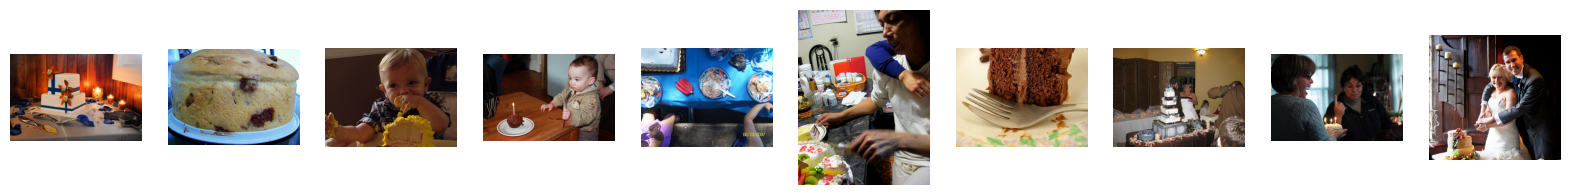

GIT Images


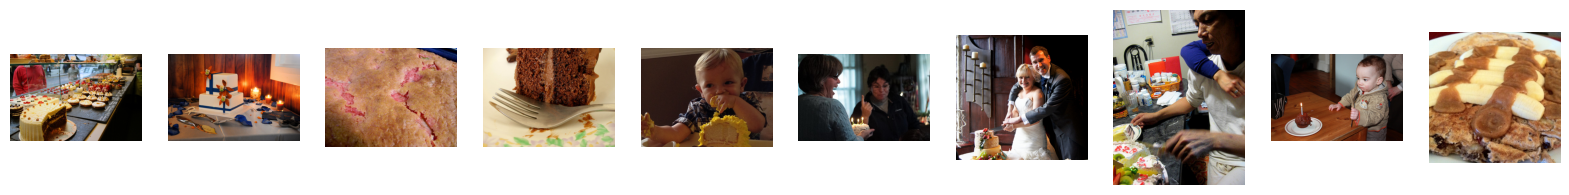

METHOD: Highest singular similarity
Precision@10: 0.7
Recall@10: 0.7
F1 score: 0.7
Mean Average Precision: 2.05
Ground Truth Images, IDs: [173383, 570471, 261116, 117425, 155179, 504711, 321214, 363207, 180560, 260470]


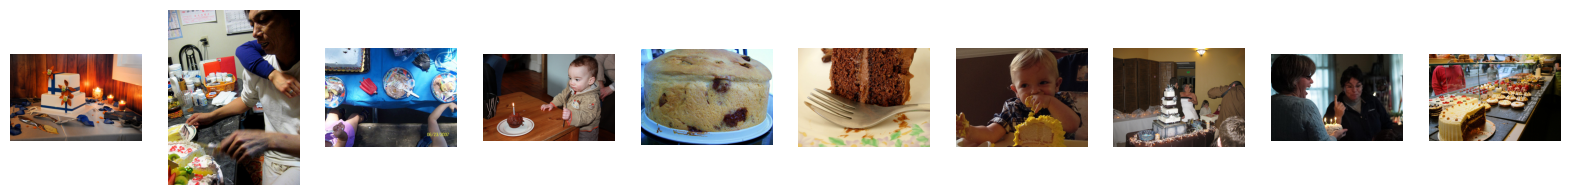

GIT Images


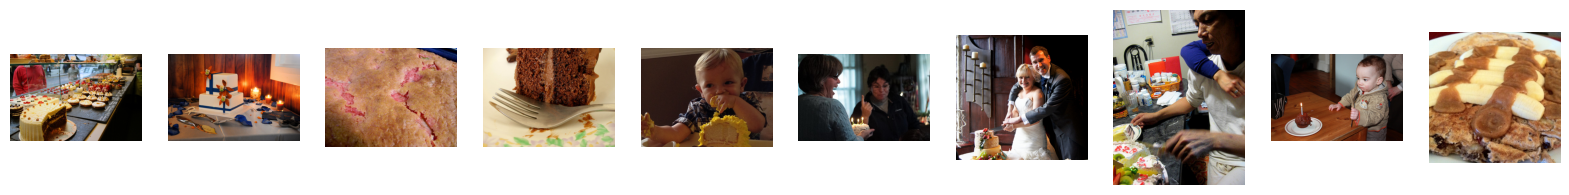

METHOD: Highest average similarity
Precision@10: 0.7
Recall@10: 0.7
F1 score: 0.7
Mean Average Precision: 2.05
Ground Truth Images, IDs: [173383, 155179, 117425, 504711, 321214, 263969, 363207, 570471, 180560, 261116]


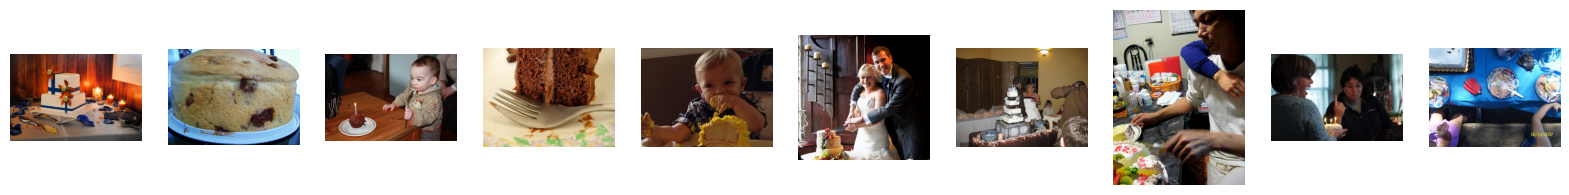

GIT Images


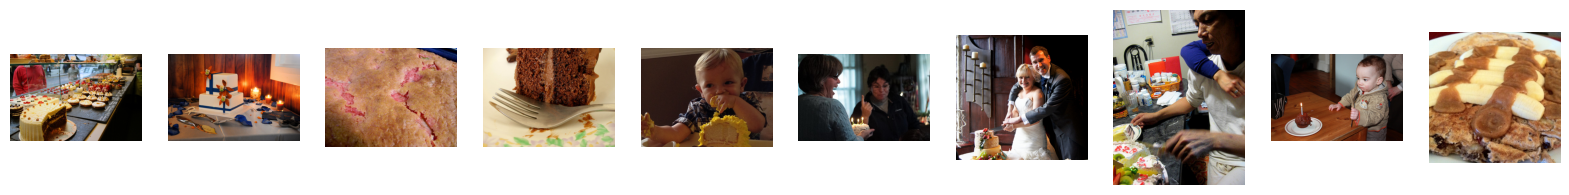

In [19]:
# Process text query
query = "birthday cake"
SIZE = 500
K = 10

evaluate(query=query, K=K, SIZE=SIZE, avg_embed_sim=True)
evaluate(query=query, K=K, SIZE=SIZE, highest_singular_sim=True)
evaluate(query=query, K=K, SIZE=SIZE, highest_avg_sim=True)

In [20]:
# print the COCO captions for the chosen image
for caption in get_coco_image_captions(coco, image_id=184791):
        print(caption)

A painting of a table with fruit on top of it.
Painting of oranges, a bowl, candle, and a pitcher
a painting of fruit and a candle with a vase
A painting of a candlestick holder with a candle, several pieces of fruit and a vase, with a gold frame around the painting.
A painting that has a gold frame on it.


In [22]:
for option in options_with_all:
    print("Option", option)
    for category in all_queries["categories"].keys():
        print(option, category)
        query_group = all_queries["categories"][category]
        performance_dict = {"precision": [], "recall": [], "f1": [], "nDCG": []}
        for query in query_group:
            if option == "avg_embed":
                
                performance_dict = search(query=query, K=10, SIZE=500,performance_dict=performance_dict, avg_embed_sim=True)
            elif option == "highest_singular_score":
                performance_dict = search(query=query, K=10, SIZE=500,performance_dict=performance_dict,  highest_singular_sim=True)            
            else: # avg_score    
                performance_dict = search(query=query, K=10, SIZE=500,performance_dict=performance_dict,  highest_avg_sim=True)
                          
        avg_performance_dict = {k: sum(v) / len(v) for k, v in performance_dict.items()}
        # round all values to 3 decimal places
        avg_performance_dict = {k: round(v, 3) for k, v in avg_performance_dict.items()}
        print(avg_performance_dict)   

Option avg_embed
avg_embed object
{'precision': 0.56, 'recall': 0.56, 'f1': 0.56, 'nDCG': 0.743}
avg_embed action
{'precision': 0.54, 'recall': 0.54, 'f1': 0.54, 'nDCG': 0.828}
avg_embed objects_with_count
{'precision': 0.48, 'recall': 0.48, 'f1': 0.48, 'nDCG': 0.658}
avg_embed reasoning
{'precision': 0.52, 'recall': 0.52, 'f1': 0.52, 'nDCG': 0.745}
avg_embed text_on_image
{'precision': 0.62, 'recall': 0.62, 'f1': 0.62, 'nDCG': 0.746}
Option highest_singular_score
highest_singular_score object
{'precision': 0.46, 'recall': 0.46, 'f1': 0.46, 'nDCG': 0.859}
highest_singular_score action
{'precision': 0.44, 'recall': 0.44, 'f1': 0.44, 'nDCG': 0.83}
highest_singular_score objects_with_count
{'precision': 0.4, 'recall': 0.4, 'f1': 0.4, 'nDCG': 0.702}
highest_singular_score reasoning
{'precision': 0.42, 'recall': 0.42, 'f1': 0.42, 'nDCG': 0.667}
highest_singular_score text_on_image
{'precision': 0.54, 'recall': 0.54, 'f1': 0.54, 'nDCG': 0.721}
Option avg_score
avg_score object
{'precision': 

{'precision': 0.48, 'recall': 0.48, 'f1': 0.48, 'nDCG': 0.701}
avg_score reasoning
{'precision': 0.46, 'recall': 0.46, 'f1': 0.46, 'nDCG': 0.749}
avg_score text_on_image
{'precision': 0.62, 'recall': 0.62, 'f1': 0.62, 'nDCG': 0.738}
